In [1]:
# Make code toggle-able for easier review.
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<i>The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a></i>.''')


# Analysis of Amazon.com's Unlocked Mobile Phone Market
## Diving into the world of Amazon ratings, reviews, and prices through the lens of the Unlocked Mobile Phone category
### Sam Fradkin
<br>

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import the data
data = pd.read_csv('Amazon_Unlocked_Mobile.csv')

In [4]:
# Rename the columns removing all blank space characters
data.columns = ['ProductName', 'BrandName', 'Price', 'Rating', 'Reviews', 'ReviewVotes']

## 1. Background Analysis: What relationships exist between ratings, reviews, and price? 

### 1A. Data Utilized

More than 400,000 Amazon.com reviews from the Unlocked Mobile Phone category were extracted by PromptCloud, a custom web-scraping service. The data was collected in December 2016 for the purposes of finding possible relational insights with respect to reviews, ratings, and price. This dataset was then made available on Kaggle.

### 1B. Summary and Findings

Let's take a look at the first few rows of the dataset.

In [5]:
# Take a preview of the dataset
data.head()

,ProductName,BrandName,Price,Rating,Reviews,ReviewVotes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


In [6]:
# Count all unique instances in the BrandName and ProductName categories.
brands = len(list(set(data['BrandName'])))
products = len(list(set(data['ProductName'])))
print(f'The dataset contains {products} unique product reviews across {brands} brands.')

The dataset contains 4410 unique product reviews across 385 brands.


In [20]:
# Create a pivot table of all grouped by BrandName running statistical functions on each, 
# sorting them by rating count and limiting the list to the top five brands.
# The data included a BrandName called "All" which included all products that were not
# given a specific value in the BrandName column.
pivot = pd.pivot_table(data,
            values = ['Rating'],
            index =  ['BrandName'],
            columns= [],
            aggfunc=[np.sum, np.mean, np.count_nonzero, np.std], 
            margins=True, fill_value=0).sort_values(by=('count_nonzero', 'Rating'), ascending=False).fillna('')
top_5_brands = pivot.reindex().head(6)[1:]

In [9]:
# Create a list of the top five most positively rated brands
top_5_brands_list = top_5_brands.index.tolist()

# Create a variable of the sum total of all ratings for the top five brands
tf_rating_sum = float(top_5_brands['sum'].sum())

# Create a variable of all ratings in the dataset
total_rating = data['Rating'].sum()

# Create a variable of the top five brands' ratio it makes up of all ratings in the set
tf_rating_ratio = ((tf_rating_sum / total_rating) * 100).round(decimals=2)

print(f'The five most positively rated brands, {top_5_brands_list[0]}, {top_5_brands_list[1]}, {top_5_brands_list[2]}, {top_5_brands_list[3]}, and {top_5_brands_list[4]}, make up {tf_rating_ratio} percent of all ratings in the sample. (Figure 1)')

The five most positively rated brands, Samsung, BLU, Apple, LG, and BlackBerry, make up 55.54 percent of all ratings in the sample. (Figure 1)


In [10]:
# Create a table of rating sums for the top 5 brands and another row of all others
brands_5_andother = top_5_brands['sum'].copy()
brands_5_andother.loc['Other']=[total_rating - tf_rating_sum]
brands_5_andother['Ratio'] = (brands_5_andother.Rating / total_rating) * 100
pd.options.display.float_format = '{:,.0f}'.format

Text(0.5,0,'Brand')

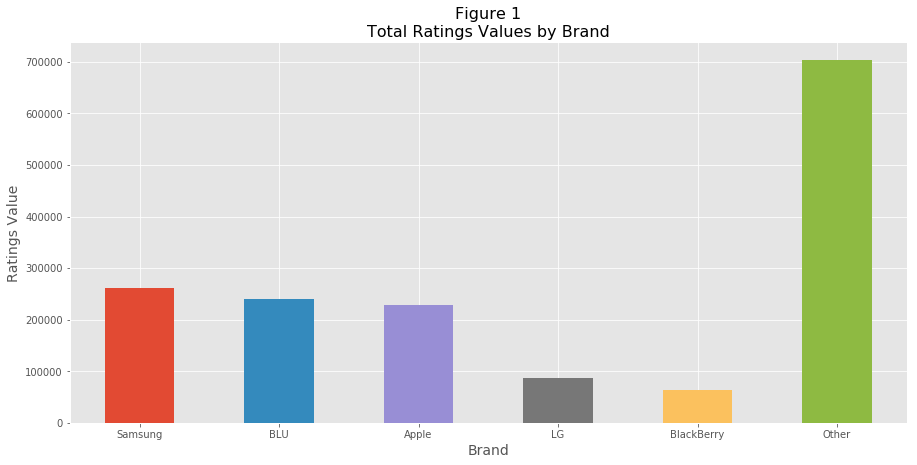

In [14]:
# Size of the plot
plt.rcParams["figure.figsize"] = "15, 7"

# Create a bar plot for Ratings Sums 
plt.style.use('ggplot')
brands_5_andother['Rating'].plot(kind = 'bar', rot=0)

# Name the axes and the plot
plt.title('Figure 1\n' + 'Total Ratings Values by Brand', fontsize=16)
plt.ylabel('Ratings Value', fontsize=14)
plt.xlabel('Brand', fontsize=14)

The dataset shows an average rating of 3.82 out of 5 stars (*Figure 2*) with some small correlation between product price and star rating. (*Figure 3*)

In [55]:
# Create a pivot table of all grouped by ProductName 
# The data included a BrandName called "All" which included all products that were not
# given a specific value in the BrandName column.
pivot2 = pd.pivot_table(data,
            values = ['Rating','Price'],
            index =  ['ProductName'],
            columns= [],
            aggfunc=[np.mean, np.count_nonzero], 
            margins=True, fill_value=0)
product_ratings = pivot2.copy().reset_index()
product_ratings.columns = ['ProductName', 'MeanPrice', 'MeanRating', 'CountPrice', 'CountRating']
product_ratings = product_ratings[product_ratings.CountRating < 100000]

In [56]:
# Create a function to add a specific star rating value into a new column based on the Rating value
def rating(r):
  if 0.0 < r['MeanRating'] < 1.5:
    return 1
  elif 1.5 <= r['MeanRating'] < 2.5:
    return 2
  elif 2.5 <= r['MeanRating'] < 3.5:
    return 3
  elif 3.5 <= r['MeanRating'] < 4.5:
    return 4
  elif 4.5 <= r['MeanRating'] < 5:
    return 5
  else:
    return ''

# Run the function to add values to the new Stars column
product_ratings['Stars'] = product_ratings.apply(rating, axis=1)

In [57]:
# Create a table of Star Ratings and their Counts
stars = product_ratings.groupby('Stars').aggregate(np.count_nonzero)
star_counts = stars[0:5].copy()

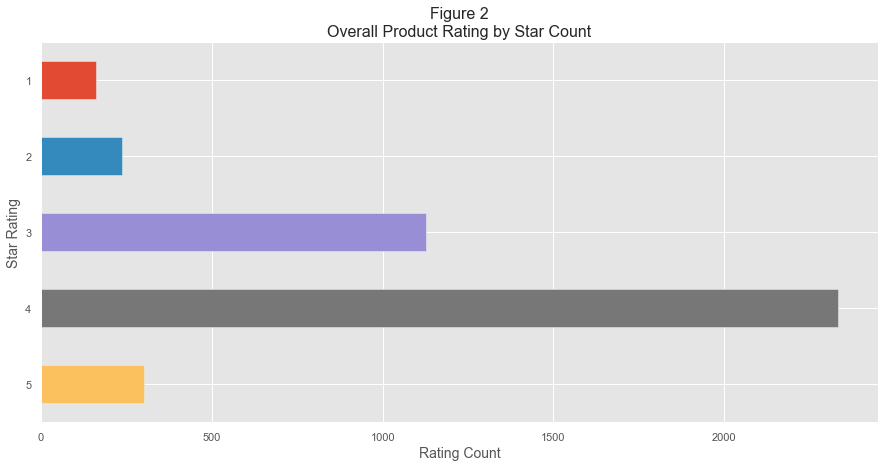

In [58]:
# Size of the plot
plt.rcParams["figure.figsize"] = "15, 7"
plt.style.use('ggplot')

# Create a bar plot for Star Rating Counts 
star_counts.CountRating.plot.barh()
plt.gca().invert_yaxis()

# Name the axes and the plot
plt.title('Figure 2\n' + 'Overall Product Rating by Star Count', fontsize=16)
plt.ylabel('Star Rating', fontsize=14)
plt.xlabel('Rating Count', fontsize=14)

plt.show()

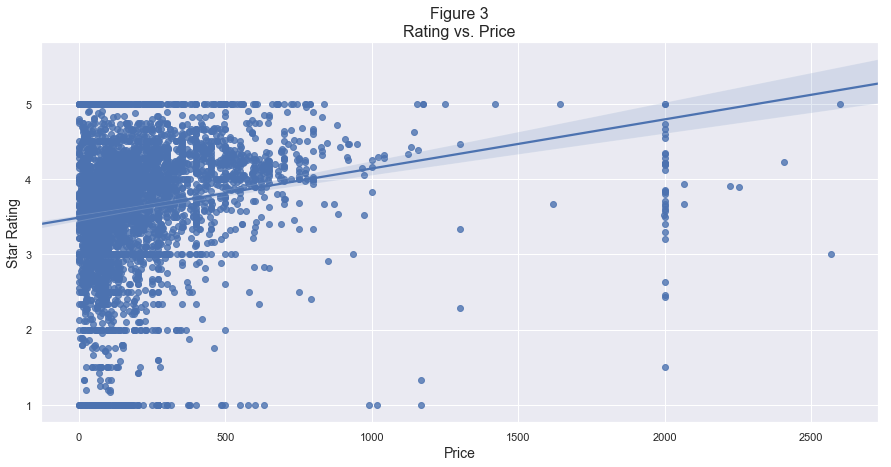

In [59]:
# Create a regression plot comparing Product Price and Rating
sns.set(color_codes=True)
ax = sns.regplot(x="MeanPrice", y="MeanRating", data=product_ratings)

# Name the axes and the plot
plt.title('Figure 3\n' + 'Rating vs. Price', fontsize=16)
plt.ylabel('Star Rating', fontsize=14)
plt.xlabel('Price', fontsize=14)

plt.show()

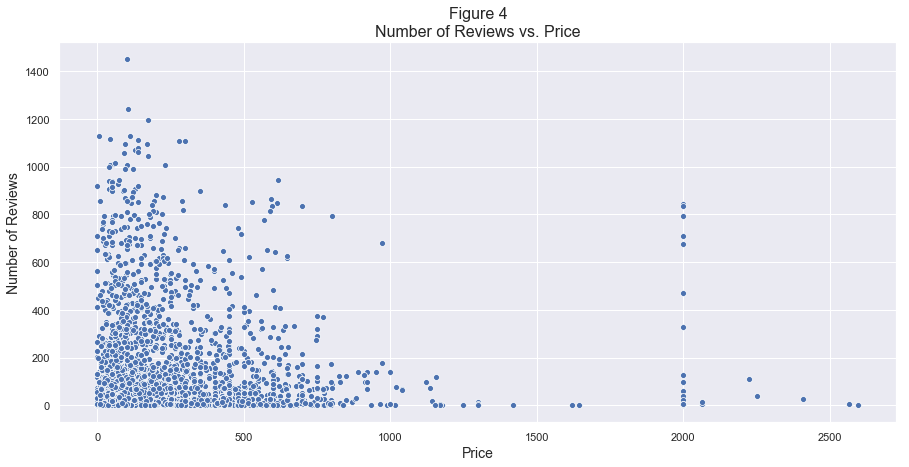

In [61]:
# Create a scatterplot comparing Product Price and Number of Reviews
sns.set(color_codes=True)
ax = sns.scatterplot(x="MeanPrice", y='CountRating', data=product_ratings)

# Name the axes and the plot
plt.title('Figure 4\n' + 'Number of Reviews vs. Price', fontsize=16)
plt.ylabel('Number of Reviews', fontsize=14)
plt.xlabel('Price', fontsize=14)

plt.show()

Looking at the data, we can learn that there is no relationship between price and the number of reviews. (*Figure 4*) Even more so, length of reviews have no relation to price as well. (*Figure 5*)

## 2. Research Proposal 

### 2A. The Problem

Amazon sellers often have a difficult time foreseeing how any specific product might sell. There are certain tricks that some sellers use to get a leg up over others and there are software plugins that offer different insights into the sellers’ world, but it is still somewhat of a shot in the dark.<br><br>
While reviews, ratings, and price are all nice and fun to know, the real statistic that matters is how many items were sold. With this information, we would be able to learn some seriously valuable statistics as to whether or not all the rest matters. For example, if we find products that are extremely expensive, have thousands of negative reviews, yet still sell a lot compared to other products, it would infer that all the rating and review data have little to no impact on sales.

### 2B. Hypothetical Solution

Amazon.com can offer a tool that indicates for sellers that provides insight into the correlation between ratings and sales. To do so, there are some serious data points that are missing from the dataset. First, data should be collected on the sum of units sold per product, as well as the number of refunded/returned purchases. This would provide insight into the weight value that ratings and reviews actually hold. Second, if possible, data should be collected on the count of impressions each review page generates. This would enable a conversion rate calculation to see how many customers viewed the rating and how it impacted their purchasing decision.<br><br>
This information will provide an answer to the following question - is a product’s overall star rating correlated with product sales. This, in turn, will help the purchasing decision process for Amazon.com sellers in their capital investment strategies.


### 2C. Hypothesis

A product’s overall star rating is correlated with product sales.

### 2D. Methods & Evaluation Plan

Conduct a test using Amazon.com’s Unlocked Mobile Phones category. Our key metric is the **Star Rating Impression Conversion Rate**. To calculate this metric, data will be collected on all sales made (or lack thereof) after viewing a  star rating. Another metric to track would be a price-based star rating impression conversion rate to see if different price brackets have different Star Rating Impression Conversion Rates. Another would be time duration between star rating impression and sale (or lack thereof).<br><br>
This test will run for two months. If after two months a significant correlation (p-value < 0.05) is found between product overall star rating and product sales, look into adding this as a feature in Amazon Seller Central. If after two months no significant correlation was found (p-value > 0.05) between product overall star rating and product sales, continue the test for another two months. If by then a significant correlation was still not found, adjust the company’s strategy regarding the entire ratings process as it seems to have a negligible effect (if any) on actual sales.